In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE



from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [2]:
def percentage_stacked_plot(dataframe, columns_to_plot, super_title, nrows=1, ncols=2):
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
                    nrows (int) : no of rows for subplots
                    ncols (int) : no of cols for subplots(max 2 for this case)
            Returns:
                    None
    '''
    number_of_columns = ncols
    number_of_rows = nrows #math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    if nrows==ncols==1:
        fig.suptitle(super_title, fontsize=15,  y=.95)
    else:
        fig.suptitle(super_title, fontsize=15,  y=.95)
    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        # calculate the percentage of observations of the response variable for each group of the independent variable
        prop_by_independent = pd.crosstab(dataframe[column], dataframe['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)
        # set title and labels
        ax.set_title("Observations % by " + column,
                     fontsize=13, loc='left')
        ax.tick_params(rotation='auto')
        ax.grid()

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

def histogram_plots(dataframe, columns_to_plot, super_title):
    '''
    Prints a histogram for each independent variable of the list columns_to_plot.
        Parameters:
            columns_to_plot (list of string): Names of the variables to plot
            super_title (string): Super title of the visualization
        Returns:
            None
    '''

    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot) / 2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(super_title, fontsize=15, y=.97)

    # loop to each demographic column name to create a subplot
    for (index, column) in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        dataframe[dataframe['Churn'] == 'No'][column].plot(
            kind='hist',
            ax=ax,
            density=True,
            alpha=0.5,
            color='springgreen',
            label='No',
            )
        dataframe[dataframe['Churn'] == 'Yes'][column].plot(
            kind='hist',
            ax=ax,
            density=True,
            alpha=0.5,
            color='salmon',
            label='Yes',
            )

        # set the legend in the upper right corner
        ax.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5,
                  0.5), title='Churn', fancybox=True)

        # set title and labels

        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=13, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

def preprocess_fct(dataframe):
  '''
    Preprocess a dataframe that's given as an input, search for string columns that can be encoded and NaN values that can be replaced.
            Parameters:
                    dataframe (pandas) : a pandas dataframe to be preprocessed
            Returns:
                    dataframe (pandas) : that was preprocessed(or X/Y after the features vs labels separation)
    '''
  # for column in dataframe.columns: 
  #   print('Column: {} - Unique Values: {}'.format(column, dataframe[column].unique()))
  # getting the cols that contain NaN values
  cols_with_nans = dataframe.columns[dataframe.isna().any()].tolist()
  print(f"Col names that contain NaN values: {cols_with_nans}")
  dataframe_with_nan = dataframe[dataframe.isna().any(axis=1)]
  print(f"Shape of dataframe with NaN values:{dataframe_with_nan.shape}\n")
  for col in cols_with_nans:
    if(dataframe[col].dtypes == 'float64'):
      dataframe[col].fillna(value=dataframe[col].mean(), inplace=True)
    elif(dataframe[col].dtypes == 'object'):
      dataframe[col].fillna(value=dataframe[col].mode()[0], inplace=True)

  # getting cols that contain <string> values and need to be encoded(transformed to numbers)
  list_of_string_cols = []
  for col in dataframe:
    if(dataframe[col].dtypes == 'object'):
      list_of_string_cols.append(col)
  print(f"Columns(#={len(list_of_string_cols)}) that contain string values: {list_of_string_cols}\n")
  le = preprocessing.LabelEncoder()
  for col in list_of_string_cols:
    dataframe[col] = le.fit_transform(dataframe[col].astype(str))
  print(f"Not Churned in dataframe: {round(len(dataframe[dataframe['Churn'] == 0]) / len(dataframe) * 100, 2)}%, # of retained customers: {len(dataframe[dataframe['Churn'] == 0])}")
  print(f"Churned in dataframe: {round(len(dataframe[dataframe['Churn'] == 1]) / len(dataframe) * 100, 2)}%, # of churned customers: {len(dataframe[dataframe['Churn'] == 1])}\n")
  # Y = dataframe['Churn']
  # X = dataframe.drop(['Churn']+['Unnamed: 0']+['CustomerID'], axis=1)
  dataframe.drop(['Unnamed: 0', 'CustomerID', 'ServiceArea', 'AgeHH1', 'AgeHH2', 'OwnsMotorcycle', 'TruckOwner', 'RVOwner', 'HandsetPrice', 
  'Homeownership', 'MaritalStatus', 'AdjustmentsToCreditRating', 'PrizmCode', 'Occupation'], axis = 1, inplace = True)
  # print(f"Shape of labels dataset: {Y.shape}\n")
  # print(f"Shape of features dataset: {X.shape}\n")
  print(dataframe.head(5))
  return dataframe

def get_outliers(col, dataframe, iqr_low = 1.5, iqr_up = 1.5):
  sns.boxplot(x = dataframe[col])
  plt.show()

  print(f"Describing df: {dataframe[col].describe()}")
  Q1 = dataframe[col].quantile(0.25)
  Q3 = dataframe[col].quantile(0.75)
  IQR = Q3 - Q1 #IQR methos used here to determine the standard values(rannge) for different cols
  print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")

  upper_lim = Q3 + iqr_up * IQR
  lower_lim = Q1 - iqr_low * IQR
  print(f"LowLim:{lower_lim}, UpLim: {upper_lim}")
  print(f"Length of df-records > UpLim: {len(dataframe[dataframe[col]>upper_lim])}")
  outliers_low = (dataframe[col] < lower_lim)
  outliers_up = (dataframe[col] > upper_lim)
  print(f"Length of remaining df after eliminating the outliers:{len(dataframe[col]) - (len(dataframe[col][outliers_low])+len(dataframe[col][outliers_up]))}"
  )
  return outliers_low, outliers_up

In [3]:
# reading the datasets
pd.set_option('display.max_columns', None)
# change the paths according to your PC/datasets files
df_train = pd.read_csv(r"C:\Users\dalia\Downloads\Vodafone-Data-Science-Test\Vodafone-Data-Science-Test\train.csv")
df_test = pd.read_csv(r"C:\Users\dalia\Downloads\Vodafone-Data-Science-Test\Vodafone-Data-Science-Test\test.csv")

In [4]:
# no of missing values or unknown values that can't be encoded/categorized and needs to be deleted in the preprocessing step(before training)
binary_cols=[]
multi_Value=[]
for col in df_train.columns:
    #print(col,df[col].dtype,df[col].dtype == 'object',df[col].unique().shape[0])
    if df_train[col].dtype =='object':
        if df_train[col].unique().shape[0]==2:
            binary_cols.append(col)
        else:
            multi_Value.append(col)
for col in binary_cols:
    if 'Unknown' in set(df_train[col]):
        print(f"Binary: {col}")
for col in multi_Value:
    if 'Unknown' or 'Other' in set(df_train[col]):
        print(f"MultiVal: {col}")

print(f"Homeownership % of missing values(Unknown=NaN): {round(df_train[df_train['Homeownership']=='Unknown'].shape[0]/df_train.shape[0] * 100,2)}%")
print(f"HandsetPrice % of missing values(Unknown=NaN): {round(df_train[df_train['HandsetPrice']=='Unknown'].shape[0]/df_train.shape[0] * 100,2)}%")
print(f"MaritalStatus % of missing values(Unknown=NaN): {round(df_train[df_train['MaritalStatus']=='Unknown'].shape[0]/df_train.shape[0] * 100,2)}%")
print(f"PrizmCode % of missing values(Unknown/Other=NaN): {round(df_train[df_train['PrizmCode']=='Other'].shape[0]/df_train.shape[0] * 100,2)}%")
print(f"Occupation % of missing values(Unknown/Other=NaN): {round(df_train[df_train['Occupation']=='Other'].shape[0]/df_train.shape[0] * 100,2)}%")

Binary: Homeownership
MultiVal: ServiceArea
MultiVal: HandsetPrice
MultiVal: CreditRating
MultiVal: PrizmCode
MultiVal: Occupation
MultiVal: MaritalStatus
Homeownership % of missing values(Unknown=NaN): 33.17%
HandsetPrice % of missing values(Unknown=NaN): 56.86%
MaritalStatus % of missing values(Unknown=NaN): 38.37%
PrizmCode % of missing values(Unknown/Other=NaN): 48.31%
Occupation % of missing values(Unknown/Other=NaN): 73.81%


In [5]:
print(f"Shape of training set: {df_train.shape}")
print(f"Shape of testing set: {df_test.shape}")

Shape of training set: (38285, 59)
Shape of testing set: (12762, 59)


Outliers for `TotalRecurringCharge` in df_train


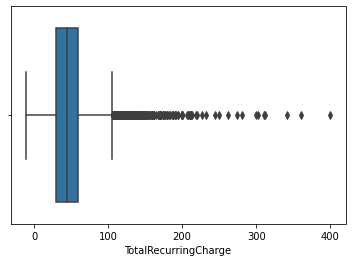

Describing df: count    38169.000000
mean        46.773272
std         23.817344
min        -11.000000
25%         30.000000
50%         45.000000
75%         60.000000
max        400.000000
Name: TotalRecurringCharge, dtype: float64
Q1=30.0, Q3=60.0, IQR=30.0
LowLim:-30.0, UpLim: 135.0
Length of df-records > UpLim: 258
Length of remaining df after eliminating the outliers:38027
Outliers for `TotalRecurringCharge` in df_test


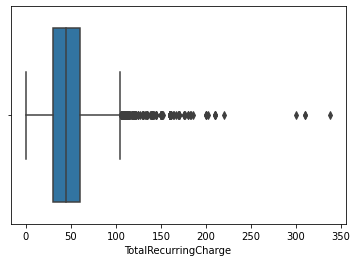

Describing df: count    12722.000000
mean        47.000550
std         23.943339
min          0.000000
25%         30.000000
50%         45.000000
75%         60.000000
max        338.000000
Name: TotalRecurringCharge, dtype: float64
Q1=30.0, Q3=60.0, IQR=30.0
LowLim:-30.0, UpLim: 135.0
Length of df-records > UpLim: 96
Length of remaining df after eliminating the outliers:12666
Shape of training set: (38027, 59)
Shape of testing set: (12666, 59)
Outliers for `PercChangeMinutes` in df_train


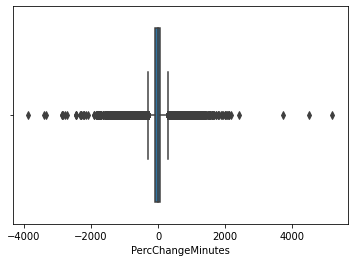

Describing df: count    37762.000000
mean       -11.431916
std        255.357255
min      -3875.000000
25%        -83.000000
50%         -5.000000
75%         65.000000
max       5192.000000
Name: PercChangeMinutes, dtype: float64
Q1=-83.0, Q3=65.0, IQR=148.0
LowLim:-379.0, UpLim: 435.0
Length of df-records > UpLim: 1233
Length of remaining df after eliminating the outliers:34930
Outliers for `PercChangeMinutes` in df_test


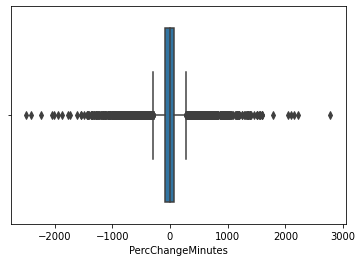

Describing df: count    12564.000000
mean        -9.014088
std        250.036543
min      -2496.000000
25%        -80.000000
50%         -4.000000
75%         66.000000
max       2778.000000
Name: PercChangeMinutes, dtype: float64
Q1=-80.0, Q3=66.0, IQR=146.0
LowLim:-372.0, UpLim: 431.0
Length of df-records > UpLim: 422
Length of remaining df after eliminating the outliers:11635
Shape of training set: (34930, 59)
Shape of testing set: (11635, 59)
Outliers for `PercChangeRevenues` in df_train


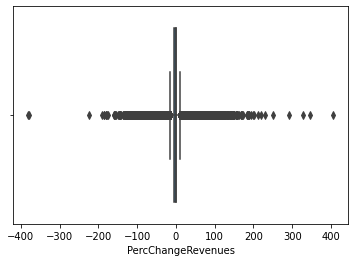

Describing df: count    34665.000000
mean        -0.892136
std         24.031570
min       -380.300000
25%         -5.600000
50%         -0.300000
75%          1.300000
max        404.700000
Name: PercChangeRevenues, dtype: float64
Q1=-5.6, Q3=1.3, IQR=6.8999999999999995
LowLim:-74.6, UpLim: 104.79999999999998
Length of df-records > UpLim: 175
Length of remaining df after eliminating the outliers:34467
Outliers for `PercChangeRevenues` in df_test


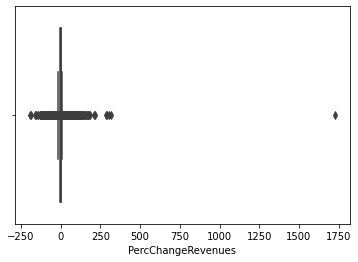

Describing df: count    11533.000000
mean        -0.725544
std         28.598137
min       -191.100000
25%         -5.400000
50%         -0.300000
75%          1.200000
max       1724.400000
Name: PercChangeRevenues, dtype: float64
Q1=-5.4, Q3=1.2, IQR=6.6000000000000005
LowLim:-71.4, UpLim: 100.20000000000002
Length of df-records > UpLim: 67
Length of remaining df after eliminating the outliers:11471
Shape of training set: (34467, 59)
Shape of testing set: (11471, 59)


In [6]:
# showing the values of different cols and its outliers( + their distribution ) using IQR method
outliers_cols = ['TotalRecurringCharge', 'PercChangeMinutes', 'PercChangeRevenues']
iqrUP = 2.5
iqrLOW = 2
for col in outliers_cols:
  if col == 'PercChangeRevenues': # needs bigger limits(both lower/upper) because of the values in this col
    iqrUP = 15
    iqrLOW = 10
  print(f"Outliers for `{col}` in df_train")
  outliers_low, outliers_up = get_outliers(col, df_train, iqrLOW, iqrUP)
  df_train = df_train[~(outliers_low | outliers_up)]
  print(f"Outliers for `{col}` in df_test")
  outliers_low, outliers_up = get_outliers(col, df_test, iqrLOW, iqrUP)
  df_test = df_test[~(outliers_low | outliers_up)]
  print(f"Shape of training set: {df_train.shape}")
  print(f"Shape of testing set: {df_test.shape}")

Train Set - col=TotalRecurringCharge


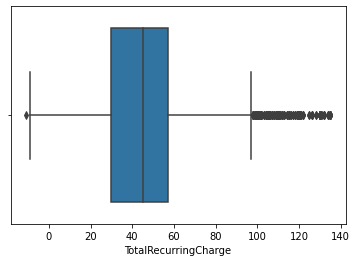

Test Set - col=TotalRecurringCharge


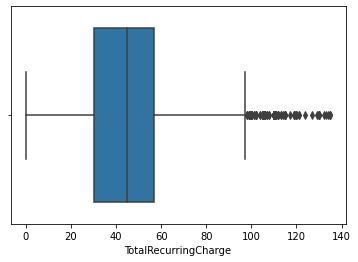



Train Set - col=PercChangeMinutes


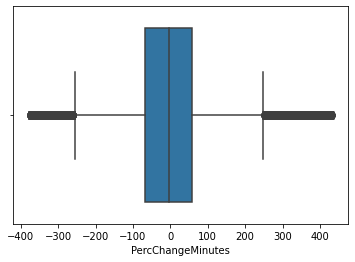

Test Set - col=PercChangeMinutes


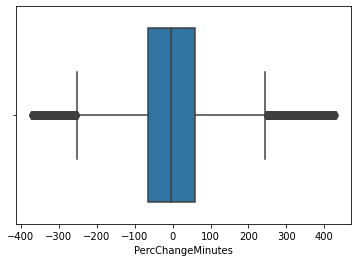



Train Set - col=PercChangeRevenues


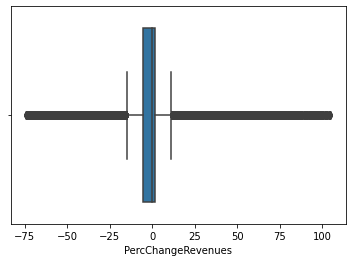

Test Set - col=PercChangeRevenues


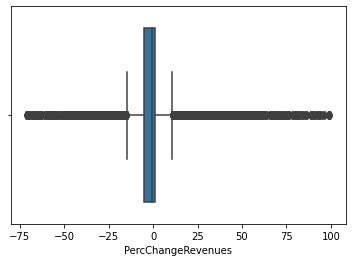

In [7]:
# show the distributions and outliers of previos columns after editing them
for col in outliers_cols:
  print(f"Train Set - col={col}")
  sns.boxplot(x = df_train[col])
  plt.show()
  print(f"Test Set - col={col}")
  sns.boxplot(x = df_test[col])
  plt.show()
  print("\n")


In [8]:
# encoding MonthsInService subscription values into categorical ones(1year and below, 2y and below and so on)
print('Column: {} - Unique Values: {}'.format('MonthsInService', df_train['MonthsInService'].unique()))
print(len(df_train['MonthsInService'].unique()))

bins = [0,12,24,36,48,60]
labels=['12M(<=)','24M(<=)','36M(<=)','48M(<=)','60M(<=)']
df_train['MonthsInService'] = pd.cut(df_train['MonthsInService'], labels=labels,bins=bins, include_lowest=True)
df_train['MonthsInService'] = df_train['MonthsInService'].astype("str")

print('Column: {} - Unique Values: {}'.format('MonthsInService', df_train['MonthsInService'].unique()))
print(len( df_train['MonthsInService'].unique()))

Column: MonthsInService - Unique Values: [12 19 10 16 26 21  9 23 24 20 11 13 27 28 38 31  7 18 14 36 39 30  8  6
 35 25 59 49 15 29 17 47 37 32 33 51 44 22 53 41 45 43 46 50 42 40 34 57
 48 52 54 55 58 56 60]
55
Column: MonthsInService - Unique Values: ['12M(<=)' '24M(<=)' '36M(<=)' '48M(<=)' '60M(<=)']
5


Churn customers / Total # of customers:9834 / 34467
% of churned customers: 28.53%
Retain customers / Total # of customers:24633 / 34467
% of retained customers: 71.47%


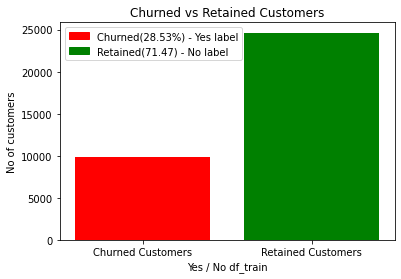

In [9]:
print(f"Churn customers / Total # of customers:{len(df_train[df_train['Churn']=='Yes'])} / {len(df_train['Churn'])}")
print(f"% of churned customers: {round(len(df_train[df_train['Churn']=='Yes'])/len(df_train['Churn'])* 100, 2)}%")
print(f"Retain customers / Total # of customers:{len(df_train[df_train['Churn']=='No'])} / {len(df_train['Churn'])}")
print(f"% of retained customers: {round(len(df_train[df_train['Churn']=='No'])/len(df_train['Churn'])* 100, 2)}%")

type_of_customers = ['Churned Customers','Retained Customers']
no_of_customers = [len(df_train[df_train['Churn']=="Yes"]), len(df_train[df_train['Churn']=="No"])]

plt.bar(type_of_customers, no_of_customers, color=['red', 'green'])
plt.title('Churned vs Retained Customers')
plt.xlabel('Yes / No df_train')
plt.ylabel('No of customers')
keys = ['Churned(' + str(round(len(df_train[df_train['Churn']=='Yes'])/len(df_train['Churn'])*100,2))+'%) - Yes label',
'Retained('+str(round(len(df_train[df_train['Churn']=='No'])/len(df_train['Churn'])*100,2))+') - No label']
colors = {keys[0]:'red',keys[1]:'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc="best")

plt.show()

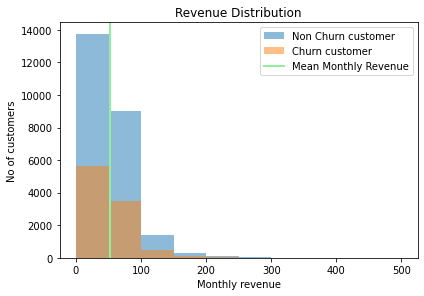

No of customer churn after making callToRetentionTeam: 513
No of customer retain after making callToRetentionTeam: 605
Sucess rate of retention call: 54.11%
Total customer accepted the retention offer: 567
Conversion rate customer making call for retention offer then accepting it: 50.72%
No of customer churn after accepting retention offer: 237
No of customer retain after accepting retention offer: 330
Success rate of  retention offer: 58.2%


In [10]:
plt.hist(df_train[df_train['Churn']=='No']['MonthlyRevenue'],bins=[0,50,100,150,200,250,300,350,400,450,500],alpha=0.5, label='Non Churn customer')
plt.hist(df_train[df_train['Churn']=='Yes']['MonthlyRevenue'],bins=[0,50,100,150,200,250,300,350,400,450,500],alpha=0.5,label='Churn customer')
mean_rev=df_train['MonthlyRevenue'].mean()
plt.axvline(mean_rev,label='Mean Monthly Revenue',color='#91ee9a',linewidth=2)
plt.ylabel("No of customers")
plt.xlabel("Monthly revenue")
plt.legend()
plt.tight_layout()
plt.title('Revenue Distribution')
plt.show()

#------------------------------------------------------------------------------------
retention_df=df_train[df_train['MadeCallToRetentionTeam']=='Yes']
print(f"No of customer churn after making callToRetentionTeam: {retention_df[retention_df['Churn']=='Yes'].shape[0]}")
print(f"No of customer retain after making callToRetentionTeam: {retention_df[retention_df['Churn']=='No'].shape[0]}")
print(f"Sucess rate of retention call: {round(retention_df[retention_df['Churn']=='No'].shape[0]/retention_df.shape[0] * 100,2)}%")

retention_offer_df=df_train[df_train['RetentionOffersAccepted']>0]
no_cust_with_ret_offer=retention_offer_df.shape[0]
print("Total customer accepted the retention offer: {}".format(no_cust_with_ret_offer))
print(f"Conversion rate customer making call for retention offer then accepting it: {round(no_cust_with_ret_offer/retention_df.shape[0] * 100, 2)}%")
print(f"No of customer churn after accepting retention offer: {retention_offer_df[retention_offer_df['Churn']=='Yes'].shape[0]}")
print(f"No of customer retain after accepting retention offer: {retention_offer_df[retention_offer_df['Churn']=='No'].shape[0]}")
print(f"Success rate of  retention offer: {round(retention_offer_df[retention_offer_df['Churn']=='No'].shape[0]/no_cust_with_ret_offer * 100, 2)}%")

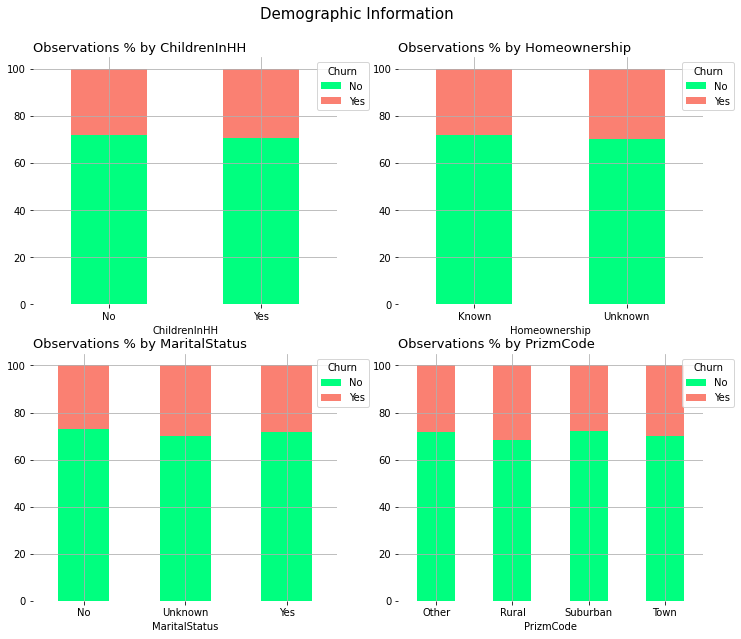

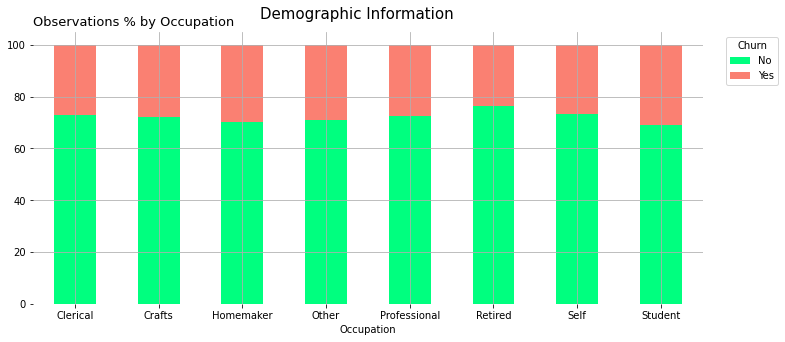

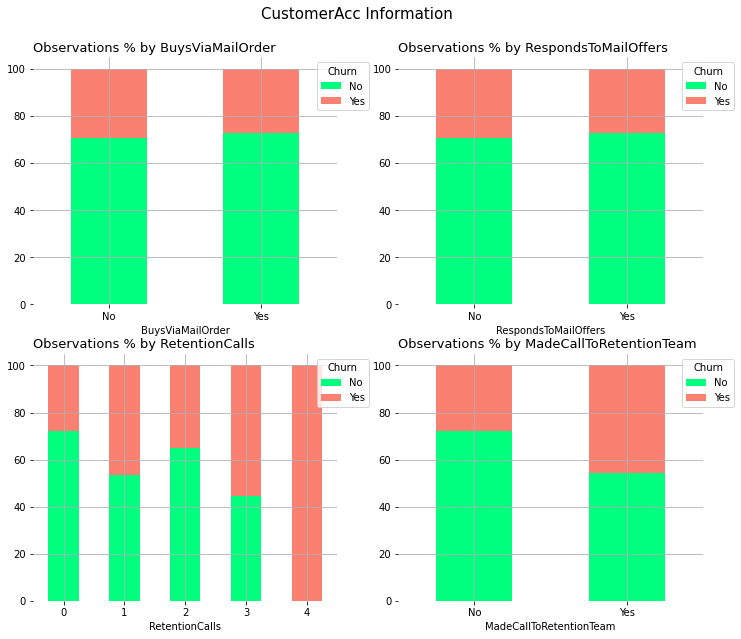

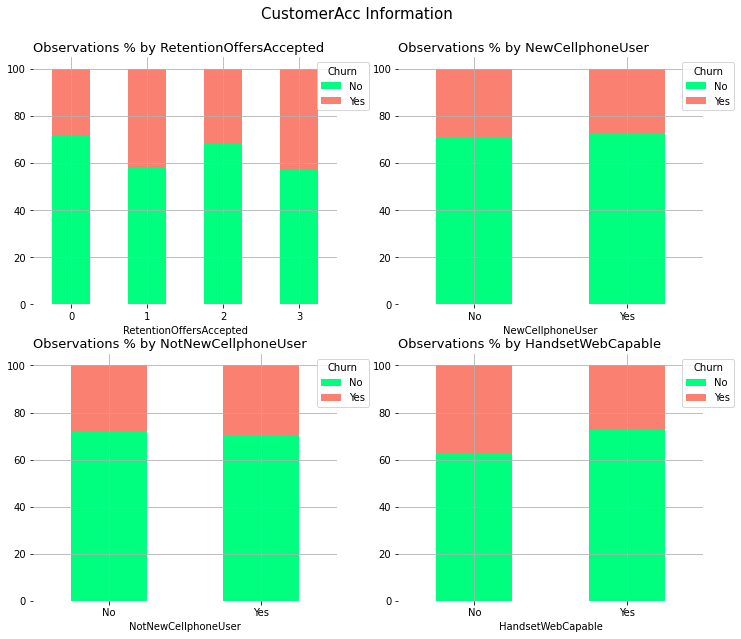

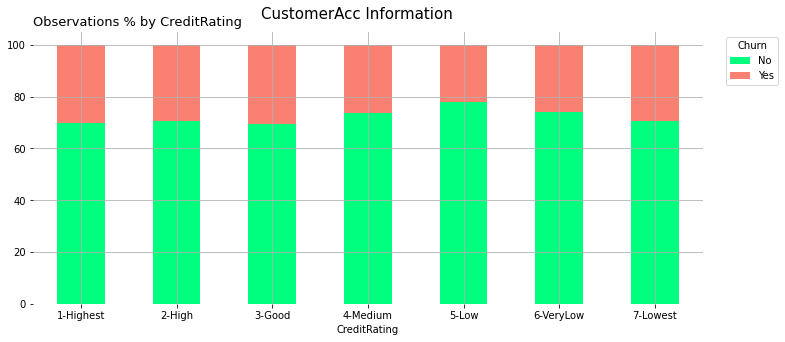

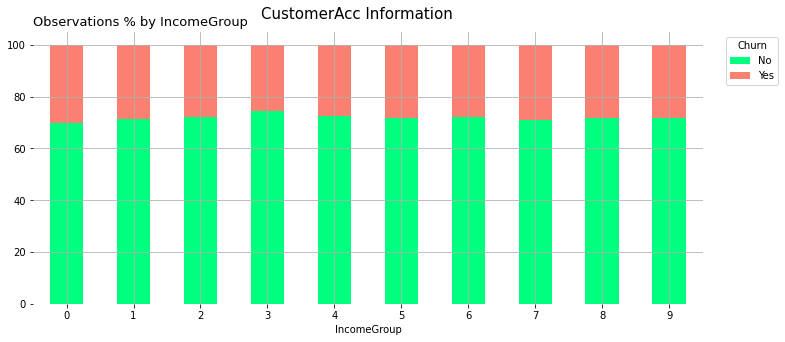

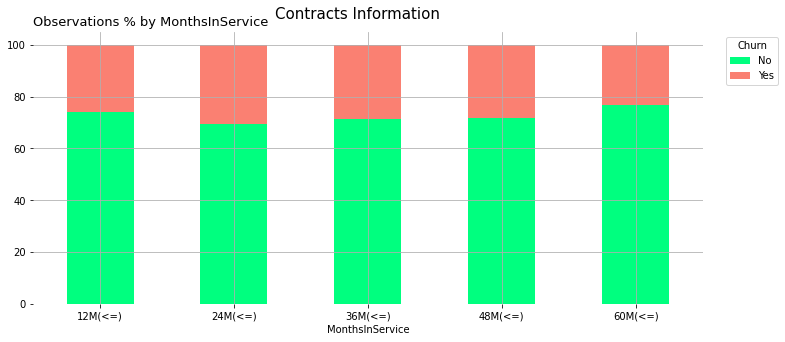

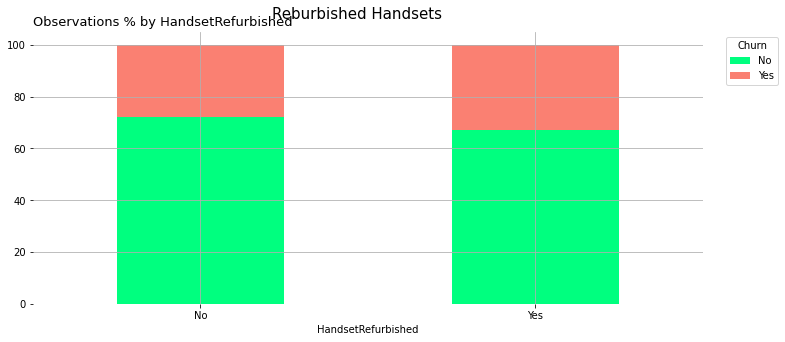

In [12]:
# details about customer
customer_details_cols = ['ChildrenInHH', 'Homeownership', 'MaritalStatus', 'PrizmCode']
percentage_stacked_plot(df_train, customer_details_cols, 'Demographic Information', math.ceil(len(customer_details_cols)/2))
percentage_stacked_plot(df_train, ['Occupation'], 'Demographic Information', 1, 1)

# customer account column names - details about his account on the TelCo comp
customer_account_cols1 = ['BuysViaMailOrder', 'RespondsToMailOffers','RetentionCalls','MadeCallToRetentionTeam']
customer_account_cols2 = ['RetentionOffersAccepted','NewCellphoneUser','NotNewCellphoneUser','HandsetWebCapable']
percentage_stacked_plot(df_train, customer_account_cols1, 'CustomerAcc Information', math.ceil(len(customer_account_cols1)/2))
percentage_stacked_plot(df_train, customer_account_cols2, 'CustomerAcc Information', math.ceil(len(customer_account_cols2)/2))
percentage_stacked_plot(df_train, ['CreditRating'], 'CustomerAcc Information', 1,1)
percentage_stacked_plot(df_train, ['IncomeGroup'], 'CustomerAcc Information', 1,1)
percentage_stacked_plot(df_train, ['MonthsInService'], 'Contracts Information', 1,1)

### FOR TESTS
percentage_stacked_plot(df_train, ['HandsetRefurbished'], 'Reburbished Handsets', 1,1)


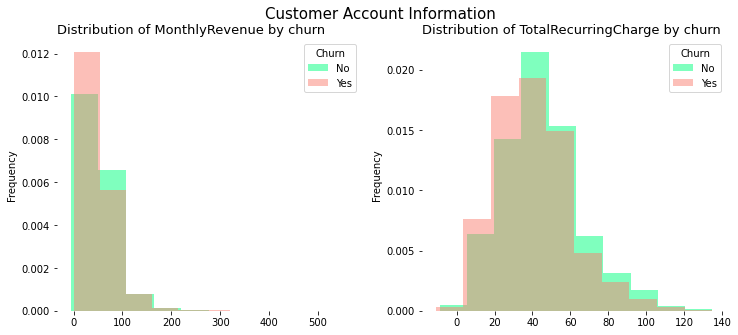

In [13]:
# customer account column names
account_columns_numeric = [ 'MonthlyRevenue','TotalRecurringCharge']

# histogram of costumer account columns
histogram_plots(df_train, account_columns_numeric, 'Customer Account Information')

In [14]:
df_train = preprocess_fct(df_train)

Col names that contain NaN values: ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'ServiceArea', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2']
Shape of dataframe with NaN values:(864, 59)

Columns(#=24) that contain string values: ['Churn', 'MonthsInService', 'ServiceArea', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']

Not Churned in dataframe: 71.47%, # of retained customers: 24633
Churned in dataframe: 28.53%, # of churned customers: 9834

   Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0      1       

Text(0.5, 1.0, "Correlation of 'Churn' with other values")

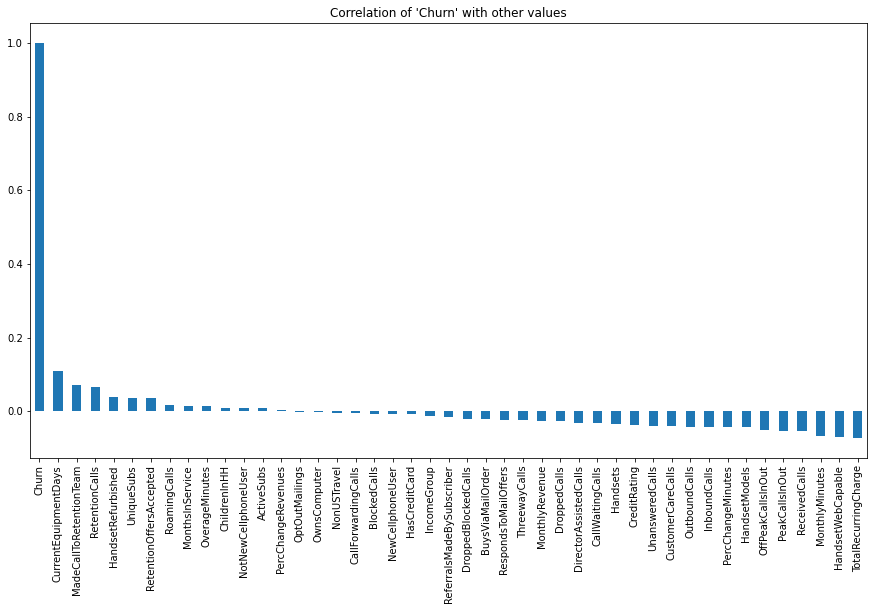

In [15]:
# correlation of df_train 'Churn' with other columns and their dependence
plt.figure(figsize=(15,8))
df_train.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.title("Correlation of 'Churn' with other values")

In [16]:
# selecting most relevant columns for churned behaviour or not
df_selected_cols = df_train[['Churn','MonthlyRevenue','MonthlyMinutes','TotalRecurringCharge','DirectorAssistedCalls',
'RoamingCalls','PercChangeMinutes','PercChangeRevenues','CustomerCareCalls',
'MonthsInService','ChildrenInHH', 'HandsetWebCapable','BuysViaMailOrder',
'RespondsToMailOffers','OwnsComputer','HasCreditCard','RetentionCalls',
'RetentionOffersAccepted','NewCellphoneUser','NotNewCellphoneUser','IncomeGroup',
'MadeCallToRetentionTeam','CreditRating']]

In [17]:
# mean/avg for each relevant column id df_churned and df_not_churned DF to distinguish the differences
df_mean_churned = pd.DataFrame(df_selected_cols[df_selected_cols['Churn'] == 1].mean(axis=0).to_dict(),index=[1])
df_mean_notchurned = pd.DataFrame(df_selected_cols[df_selected_cols['Churn'] == 0].mean(axis=0).to_dict(),index=[0])

print(df_mean_churned)
print("\n\n")
print(df_mean_notchurned)

   Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
1    1.0       51.083028      403.510181             42.355914   

   DirectorAssistedCalls  RoamingCalls  PercChangeMinutes  PercChangeRevenues  \
1               0.664699      1.059472           -9.78072           -0.634906   

   CustomerCareCalls  MonthsInService  ChildrenInHH  HandsetWebCapable  \
1           1.286109           1.0241      0.254728           0.862619   

   BuysViaMailOrder  RespondsToMailOffers  OwnsComputer  HasCreditCard  \
1          0.357128              0.370653      0.192089       0.685581   

   RetentionCalls  RetentionOffersAccepted  NewCellphoneUser  \
1        0.056539                 0.025422          0.187106   

   NotNewCellphoneUser  IncomeGroup  MadeCallToRetentionTeam  CreditRating  
1              0.14216     4.363026                 0.052166      1.711308  



   Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0    0.0       52.910666      470.211416              

<AxesSubplot:title={'center':'NotChurned'}>

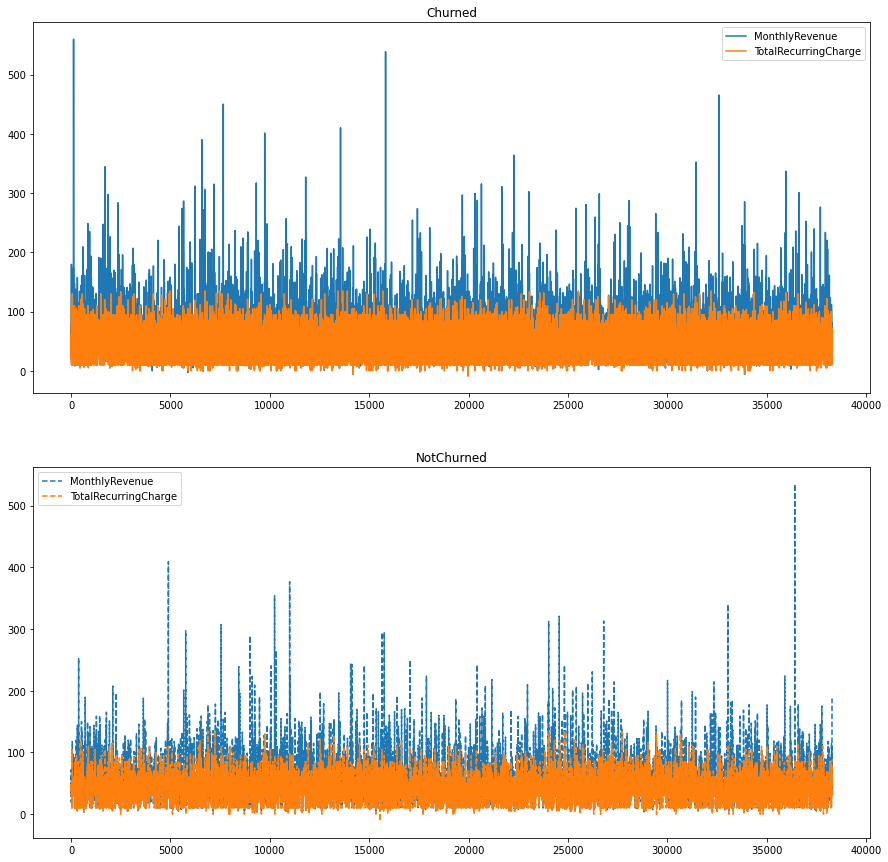

In [18]:
# monthlyRevenue vs totalRecurringCharge
df = df_selected_cols[df_selected_cols['Churn'] == 0]
df2 = df_selected_cols[df_selected_cols['Churn'] == 1]
# print(df)
# print(df2)
fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(15,15))
# ax2 = ax.twinx()

df.plot(y=["MonthlyRevenue", "TotalRecurringCharge"], ax=ax, title="Churned")
df2.plot(y=["MonthlyRevenue", "TotalRecurringCharge"], ax=ax2, ls="--", title="NotChurned")

# plt.show()

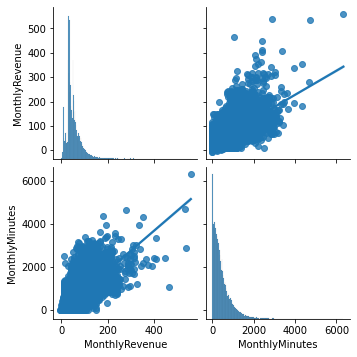

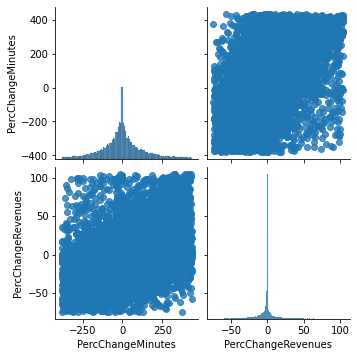

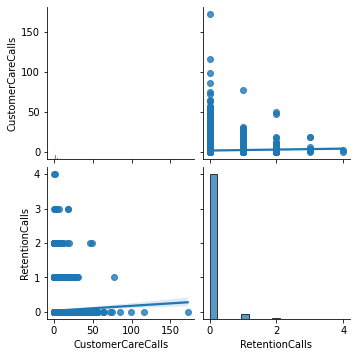

In [19]:
# correlation between some preferred columns
cols = ['MonthlyRevenue', 'MonthlyMinutes']
sns.pairplot(df_selected_cols[cols], kind="reg")
plt.show()

cols = ['PercChangeMinutes', 'PercChangeRevenues']
sns.pairplot(df_selected_cols[cols], kind="reg")
plt.show()

cols = ['CustomerCareCalls', 'RetentionCalls'] # retentionoffers and so on
sns.pairplot(df_selected_cols[cols], kind="reg")
plt.show()

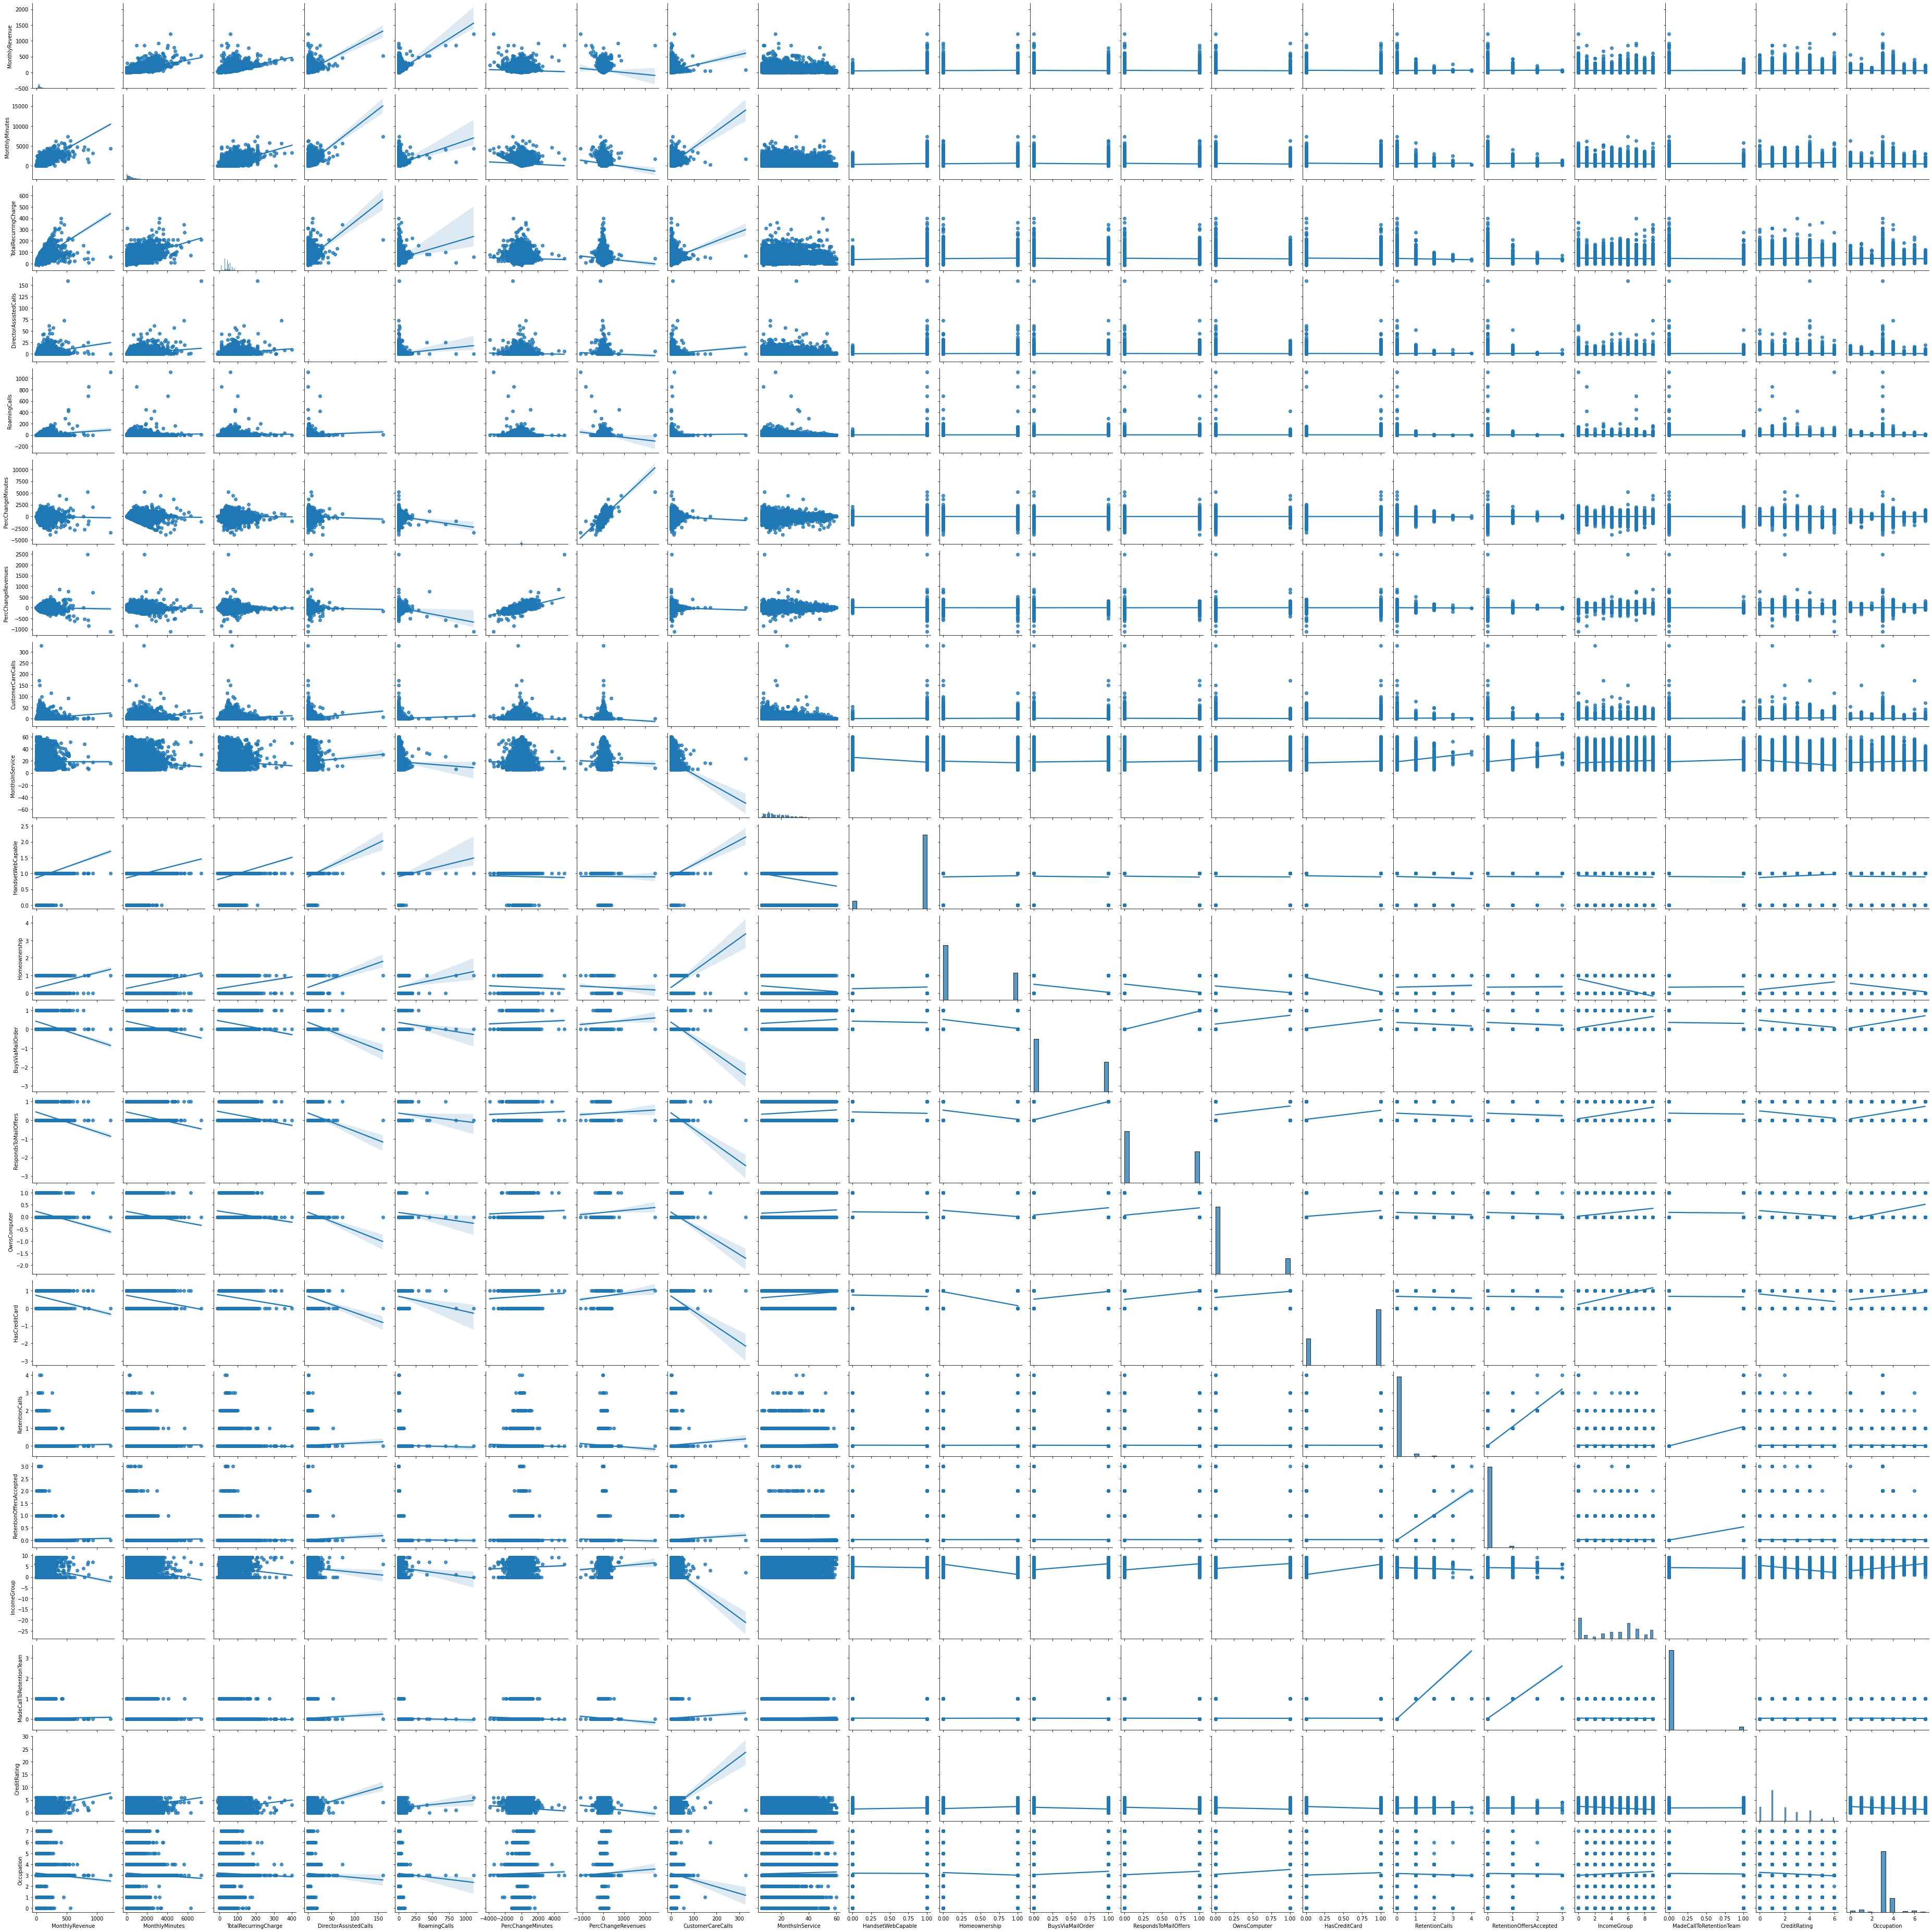

In [ ]:
# this entire correlogram takes almost 20 to 30mins to finish/show
 
# # with regression
# cols = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'RoamingCalls',
#         'PercChangeMinutes', 'PercChangeRevenues', 'CustomerCareCalls', 'MonthsInService', 'HandsetWebCapable', 
#         'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OwnsComputer', 'HasCreditCard',
#         'RetentionCalls', 'RetentionOffersAccepted', 'IncomeGroup', 'MadeCallToRetentionTeam', 'CreditRating', 'Occupation']
# sns.pairplot(df_selected_cols[cols], kind="reg")
# plt.show()

In [20]:
print("---" * 50)
print("~-~" * 50)
print("ZONA DELIMITATA SUS - ANALYTICS, JOS - PREDICTIVE")
print("~-~" * 50)
print("---" * 50)

------------------------------------------------------------------------------------------------------------------------------------------------------
~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~
ZONA DELIMITATA SUS - ANALYTICS, JOS - PREDICTIVE
~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~~-~
------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:
# transforming the months values in categorical values(to reduce complexity) and preprocessing phase before training models, optimizing...
print('Column: {} - Unique Values: {}'.format('MonthsInService', df_test['MonthsInService'].unique()))
print(len(df_test['MonthsInService'].unique()))

bins = [0,12,24,36,48,60]
labels=['12M(<=)','24M(<=)','36M(<=)','48M(<=)','60M(<=)']
df_test['MonthsInService'] = pd.cut(df_test['MonthsInService'], labels=labels,bins=bins, include_lowest=True)
df_test['MonthsInService'] = df_test['MonthsInService'].astype("str")

print('Column: {} - Unique Values: {}'.format('MonthsInService', df_test['MonthsInService'].unique()))
print(len( df_test['MonthsInService'].unique()))
df_test = preprocess_fct(df_test)


Column: MonthsInService - Unique Values: [15 11 25 13 18 17 16 28 36 10 27  7 30 24  9 21 23  6 14 59  8 12 26 22
 32 19 20 44 35 31 37 33 39 48 38 29 34 45 47 49 41 52 43 57 40 42 54 46
 53 51 50 55 58 61 56 60]
56
Column: MonthsInService - Unique Values: ['24M(<=)' '12M(<=)' '36M(<=)' '60M(<=)' '48M(<=)' 'nan']
6
Col names that contain NaN values: ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'ServiceArea', 'AgeHH1', 'AgeHH2']
Shape of dataframe with NaN values:(297, 59)

Columns(#=24) that contain string values: ['Churn', 'MonthsInService', 'ServiceArea', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice', 'MadeCallToRetentionTeam', 'Cr

In [22]:
# # Resampling the minority class - oversampling minority class ( SMOTE method ) - didn't gave a better result than not doing it
# sm = SMOTE(sampling_strategy='minority', random_state=42)
# # Fit the model to generate the data.
# oversampled_X, oversampled_Y = sm.fit_resample(df_train.drop('Churn', axis=1), df_train['Churn'])
# oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
# print(oversampled['Churn'].value_counts())
# print(oversampled.shape)
# print(len(oversampled[oversampled['Churn']==1]))
# print(len(oversampled[oversampled['Churn']==0]))

In [23]:
y_train = df_train['Churn'] # or, to use SMOTE, put oversampled insted of df_train
x_train = df_train.drop(['Churn'], axis = 1) # or, to use SMOTE, put oversampled insted of df_train

y_test = df_test['Churn']
x_test = df_test.drop(['Churn'], axis = 1)

scaler = preprocessing.StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalzied = scaler.transform(x_test)
# print(x_train_normalized)

In [24]:
### got to know the best rf model for my data - used GridSearchCV for LinearSVC and RandomForest
# max_depth=[2, 8, 16, 24, 32, 40, 48, 56, 100]
# n_estimators = [64, 128, 256, 484, 512, 700, 750, 1000]
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# # Build the grid search
# dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
# grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 3, verbose = 5)
# grid_results = grid.fit(x_train_normalized, y_train)

# # Summarize the results in a readable format
# print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
# results_df = pd.DataFrame(grid_results.cv_results_)
# results_df

In [25]:
lsvc = LinearSVC(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=3)
print(lsvc)

lsvc.fit(x_train_normalized, y_train)
score = lsvc.score(x_train_normalized, y_train)
print("Score - LinearSVC - train: ", score)

LinearSVC(C=10, dual=False, max_iter=10000, verbose=3)
[LibLinear]Score - SVM - train:  0.7154669684045609


In [26]:
rf = RandomForestClassifier(max_depth = 48, n_estimators = 64)
print(rf)

rf.fit(x_train_normalized, y_train)
score = rf.score(x_train_normalized, y_train)
print("Score - RF - train: ", score)

RandomForestClassifier(max_depth=48, n_estimators=64)
Score - RF - train:  0.9999419734818812


In [27]:
y_test_lsvc = lsvc.predict(x_test_normalzied)
y_test_rf = rf.predict(x_test_normalzied)

print('LinearSVC- testing set: '+str(accuracy_score(y_test, y_test_lsvc))+"%")
print('RF- testing set: '+str(accuracy_score(y_test, y_test_rf))+"%")

LinearSVC- testing set: 0.7138000174352715%
RF- testing set: 0.7185075407549473%


In [28]:
score_lsvc = lsvc.score(x_test_normalzied, y_test)
score_rf = rf.score(x_test_normalzied, y_test)

print("Score - LSVC - test: ", score_lsvc)
print("Score - RF - test: ", score_rf)

Score - LSVC - test:  0.7138000174352715
Score - RF - test:  0.7185075407549473


In [29]:
# extracting the best threshold value for predicted classes ( predicted values with values like 0, 0.1, 0.15, 0.2, 0.25 ... 1 )
# standard thresold wre 0.5 to classify(<0.5=0 for notChurned, >0.5=1 for Churned)
step_factor = 0.05 
threshold_value = 0.15 
roc_score=0
predicted_proba = rf.predict_proba(x_test_normalzied) #probability of prediction
while threshold_value <=0.9: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted): #store the threshold for best classification
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.15 -- 0.5440645615172454
Threshold 0.2 -- 0.5687536125404571
Threshold 0.25 -- 0.5928030769405266
Threshold 0.3 -- 0.5917821821483006
Threshold 0.35 -- 0.5866595195636461
Threshold 0.39999999999999997 -- 0.5715134703266879
Threshold 0.44999999999999996 -- 0.552706918631523
Threshold 0.49999999999999994 -- 0.5319531581942378
Threshold 0.5499999999999999 -- 0.5195574900042788
Threshold 0.6 -- 0.511462246685641
Threshold 0.65 -- 0.5069561691109937
Threshold 0.7000000000000001 -- 0.5046577613673487
Threshold 0.7500000000000001 -- 0.5033087811167241
Threshold 0.8000000000000002 -- 0.5019300088335149
Threshold 0.8500000000000002 -- 0.500888481612962
---Optimum Threshold --- 0.25 --ROC-- 0.5928030769405266


In [31]:
threshold = 0.3

predicted_proba = rf.predict_proba(x_test_normalzied)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
print(f"Accuracy(%) for the modified threshold: {accuracy}")

0.593409467352454


In [32]:
cm_lsvc = confusion_matrix(y_test, y_test_lsvc)
cm_rf = confusion_matrix(y_test, y_test_rf)

print(f"Confusion matrix-LSVC:\n{cm_lsvc}")
print(f"Confusion matrix-RF:\n{cm_rf}")
print('Accuracy lsvc: ' + str(accuracy_score(y_test, y_test_lsvc)))
print('Accuracy rf: ' + str(accuracy_score(y_test, y_test_rf)))

[[8095  109]
 [3174   93]]
[[7952  252]
 [2977  290]]
Accuracy lsvc: 0.7138000174352715
Accuracy rf: 0.7185075407549473


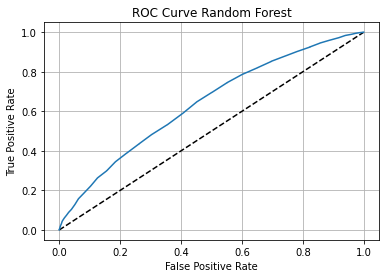

In [33]:
# Random Forest Classification
Y_predict_proba = rf.predict_proba(x_test_normalzied)
Y_predict_proba = Y_predict_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, Y_predict_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.grid(True)
plt.show()

""" Things that I did in addition - to get a better result/model/auc-roc curve 
 - used in past: 
Oversampling(minority class) & undersampling(majority class) -> same result(maybe less precise);
SMOTE oversampling(minority class - building neighbours,not copying same data points)->same result(less accuracy, bigger recall - idkwhy);
Ensemble methods(stacking & boosting, not sure but also bagging???) -> same results(couldn't get past the 72% accuracy);
Sequential method/neural network(used first time); also used SHAP, on a really basic level, for error analysis to improve the accuracy of the model with no good results;
"""

In [38]:
# Approach #1
from sklearn.ensemble import AdaBoostClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(x_train_normalized, y_train)
y_pred_dtc =clf.predict(x_test_normalzied)

print("DecisionTreeClassifier model")
print("f1 score : ", f1_score(y_test, y_pred_dtc, average="macro"))
print("precision : ",precision_score(y_test, y_pred_dtc, average="macro"))
print("recall : ",recall_score(y_test, y_pred_dtc, average="macro")) 

clf = AdaBoostClassifier(random_state = 101)
clf = clf.fit(x_train_normalized, y_train)
y_pred_ada =clf.predict(x_test_normalzied)
print("AdaBoostClassifier model")
print("f1 score : ", f1_score(y_test, y_pred_ada, average="macro"))
print("precision : ",precision_score(y_test, y_pred_ada, average="macro"))
print("recall : ",recall_score(y_test, y_pred_ada, average="macro"))  

f1 score :  0.5373056024584132
precision :  0.5369472165199154
recall :  0.5378665688547786
f1 score :  0.4846437359415835
precision :  0.631294088937401
recall :  0.5258948355054468


In [41]:
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state = 101,base_estimator=DecisionTreeClassifier())


# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[25,50,120], 
              'learning_rate':[0.1, 0.5, 1.0],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train_normalized,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train_normalized, y_train)).predict(x_test_normalzied)
best_predictions = best_clf.predict(x_test_normalzied)

In [42]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_pred_ada)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, y_pred_ada, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.7182
F-score on testing data: 0.2485

Optimized Model
------
Final accuracy score on the testing data: 0.7017
Final F-score on the testing data: 0.3593


>lr 0.714 (0.002)
>knn 0.672 (0.005)
>rf 0.721 (0.004)
>svm 0.715 (0.002)
>stacking 0.721 (0.004)


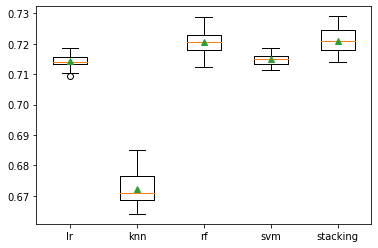

In [45]:
# # Approach #2 - get a stacking ensemble of different models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('rf', RandomForestClassifier()))
	level0.append(('svm', LinearSVC()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['rf'] = RandomForestClassifier()
	models['svm'] = LinearSVC()
	# models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = (x_train_normalized, y_train)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [58]:
# Approach #3
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
X = x_train_normalized
Y = y_train
seed = 3
kfold = model_selection.KFold(n_splits=10)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = RandomForestClassifier()
estimators.append(('rf', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

Classifier: k_nearest_neighbors, Accuracy: 0.6655914915874814)
Classifier: logistic_regression, Accuracy: 0.7132769592886409)


C:\Users\dalia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classifier: support_vector_machines, Accuracy: 0.7134513120041844)
Classifier: random_forest, Accuracy: 0.7208613024147851)
Classifier: gradient_boosting, Accuracy: 0.7220817714235899)
{'n_estimators': 120, 'min_samples_split': 2, 'max_features': None, 'max_depth': 4}
[[7965  239]
 [2927  340]]
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      8204
           1       0.59      0.10      0.18      3267

    accuracy                           0.72     11471
   macro avg       0.66      0.54      0.51     11471
weighted avg       0.69      0.72      0.65     11471

0.7239996512945689


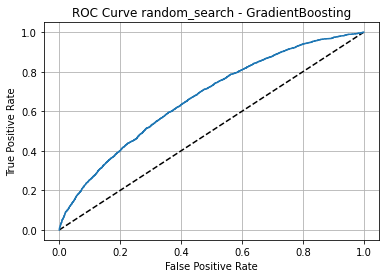

In [46]:
# Approach #4
def create_models(seed=2):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', LinearSVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model with the training data
    model.fit(x_train_normalized, y_train) #.predict(x_test_normalized)
    # make predictions with the testing data
    predictions = model.predict(x_test_normalzied)
    # calculate accuracy 
    accuracy = accuracy_score(y_test, predictions)
    # append the model name and the accuracy to the lists
    results.append(accuracy)
    names.append(name)
    # print classifier accuracy
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

# define the parameter grid
grid_parameters = {'n_estimators': [80, 90, 100, 110, 115, 120],
                   'max_depth': [3, 4, 5, 6],
                   'max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=grid_parameters,
                                   cv=3,
                                   n_iter=75,
                                   n_jobs=-1)

# fitting the model for random search 
random_search.fit(x_train_normalized, y_train)
# print best parameter after tuning
print(random_search.best_params_)

random_search_predictions = random_search.predict(x_test_normalzied)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
print(confusion_matrix)
print(classification_report(y_test, random_search_predictions))
print(accuracy_score(y_test, random_search_predictions))

Y_predict_proba = random_search.predict_proba(x_test_normalzied)
Y_predict_proba = Y_predict_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, Y_predict_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve random_search - GradientBoosting')
plt.grid(True)
plt.show()

In [59]:
print("\nUnoptimized Model - GradientBoosting - best model in this ensemble\n------")
print('Accuracy: {}, F-score: {})'.format(accuracy_score(y_test, models[4][1].predict(x_test_normalzied)), fbeta_score(y_test, models[4][1].predict(x_test_normalzied), beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, random_search_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, random_search_predictions, beta = 0.5)))


Unoptimized Model - GradientBoosting - best model in this ensemble
------
Accuracy: 0.7220817714235899, F-score: 0.23679225426226058)

Optimized Model
------
Final accuracy score on the testing data: 0.7240
Final F-score on the testing data: 0.3045


In [48]:
# Approach #5 - DL Layers
model = Sequential()
model.add(Dense(16, input_shape=(x_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(x_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                720       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
2758/2758 [==============================] - 7s 2ms/step - loss: 1.3570 - accuracy: 0.6304 - val_loss: 0.7545 - val_accuracy: 0.5914
Epoch 2/80
2758/2758 [==============================] - 6s 2ms/step - loss: 0.6867 - accuracy: 0.6751 - val_loss: 0.6234 - val_accuracy: 0.6897
Epoch 3/80
2758/2758 [========

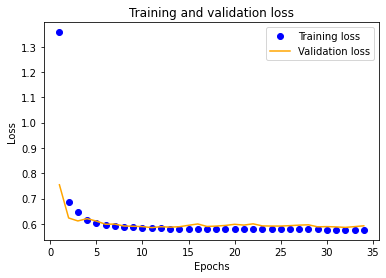

In [49]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

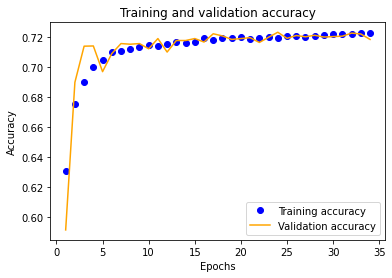

0.7230925559997559

In [50]:
# Learning curve(accuracy)
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
print(np.max(val_acc))

print(model.predict(x_test)) # prob of successes (churned)
print(np.round(model.predict(x_test),0)) # 1 and 0 (churned or not)
# print(Y) # 1 and 0 (churned or not)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict(x_test),0)

print(classification_report(y_test, preds))
Y_predict_proba = model.predict(x_test_normalzied)
fpr, tpr, thresholds = roc_curve(y_test, Y_predict_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve NN - Sequential')
plt.grid(True)
plt.show()